C:\Users\josia\AppData\Local\Programs\Python\Python313\Lib\site-packages\tqdm\auto.py:21: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm


Response 1: 
Hello Alice! It's great to meet you. I'm happy to help you with any questions or problems related to Python programming.

TOOL_CALL: save_recall_memory("Alice")

What would you like to know about Python? Do you have a specific question or topic in mind, or do you just want to chat and learn more about the language?

Tool executed: Memory saved: Alice
Response 2: 
Hello Alice! I'm glad to hear that you enjoy Python programming. As for what I remember about you, I have a few things in my memory bank.

TOOL_CALL: search_recall_memories("Alice")

I recall that you mentioned your name is Alice and you love Python programming. Additionally, I have information about your preferences and context related to the language.

Tool executed: Memory searched: Alice

Found memories: ['Alice']


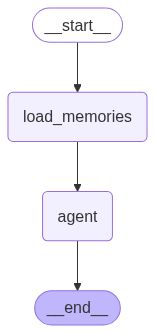

In [1]:
import json
import uuid
from typing import List, Literal, Optional

# Core imports
from langchain_core.messages import HumanMessage, AIMessage
from langchain_core.messages.utils import get_buffer_string
from langchain_core.prompts import ChatPromptTemplate
from langchain_core.runnables import RunnableConfig
from langchain_core.documents import Document
from langchain_core.vectorstores import InMemoryVectorStore
from langchain_core.tools import tool

# LangGraph imports
from langgraph.graph import StateGraph, START, END
from langgraph.graph.message import MessagesState
from langgraph.prebuilt import ToolNode
from langgraph.checkpoint.memory import MemorySaver

# Model imports - using newer langchain-ollama
from langchain_ollama import ChatOllama
from transformers import AutoTokenizer

# Embeddings - using local HuggingFace embeddings to avoid OpenAI dependency
from langchain_huggingface import HuggingFaceEmbeddings

# Initialize model and tokenizer
model = ChatOllama(
    model="codellama",
    temperature=0.1,
)
tokenizer = AutoTokenizer.from_pretrained("codellama/CodeLlama-7b-hf")

# Local vector storage for memory
embeddings = HuggingFaceEmbeddings(
    model_name="sentence-transformers/all-MiniLM-L6-v2"
)
recall_vector_store = InMemoryVectorStore(embeddings)

def get_user_id(config: RunnableConfig) -> str:
    """Gets unique user id"""
    user_id = config["configurable"].get("user_id")
    if user_id is None:
        raise ValueError("User ID needs to be provided to save a memory.")
    return user_id

# Memory recall and searching tools
@tool
def save_recall_memory(memory: str, config: RunnableConfig) -> str:
    """Save memory to vectorstore for later retrieval"""
    user_id = get_user_id(config)
    document = Document(
        page_content=memory, 
        id=str(uuid.uuid4()), 
        metadata={"user_id": user_id}
    )
    recall_vector_store.add_documents([document])
    return f"Memory saved: {memory}"

@tool
def search_recall_memories(query: str, config: RunnableConfig) -> List[str]:
    """Search for relevant memories"""
    user_id = get_user_id(config)
    
    def __filter_function(doc: Document) -> bool:
        """Filters relevant information in memory"""
        return doc.metadata.get("user_id") == user_id
    
    documents = recall_vector_store.similarity_search(
        query, k=3, filter=__filter_function
    )
    return [document.page_content for document in documents]

# Define tools list
tools = [save_recall_memory, search_recall_memories]

# Since Ollama doesn't support native tool binding, we'll handle tools manually

class State(MessagesState):
    """Add memories that will be retrieved based on the conversation context"""
    recall_memories: List[str]

# Define the prompt template for the agent
prompt = ChatPromptTemplate.from_messages([
    (
        "system",
        "You are a helpful assistant with advanced long-term memory"
        " capabilities. Powered by a stateless LLM, you must rely on"
        " external memory to store information between conversations."
        " Utilize the available memory tools to store and retrieve"
        " important details that will help you better attend to the user's"
        " needs and understand their context.\n\n"
        "Memory Usage Guidelines:\n"
        "1. Actively use memory tools (save_recall_memory, search_recall_memories)"
        " to build a comprehensive understanding of the user.\n"
        "2. Make informed suppositions and extrapolations based on stored"
        " memories.\n"
        "3. Regularly reflect on past interactions to identify patterns and"
        " preferences.\n"
        "4. Update your mental model of the user with each new piece of"
        " information.\n"
        "5. Cross-reference new information with existing memories for"
        " consistency.\n"
        "6. Prioritize storing emotional context and personal values"
        " alongside facts.\n"
        "7. Use memory to anticipate needs and tailor responses to the"
        " user's style.\n"
        "8. Recognize and acknowledge changes in the user's situation or"
        " perspectives over time.\n"
        "9. Leverage memories to provide personalized examples and"
        " analogies.\n"
        "10. Recall past challenges or successes to inform current"
        " problem-solving.\n\n"
        "## Recall Memories\n"
        "Recall memories are contextually retrieved based on the current"
        " conversation:\n{recall_memories}\n\n"
        "## Instructions\n"
        "Engage with the user naturally, as a trusted colleague or friend."
        " There's no need to explicitly mention your memory capabilities."
        " Instead, seamlessly incorporate your understanding of the user"
        " into your responses. Be attentive to subtle cues and underlying"
        " emotions. Adapt your communication style to match the user's"
        " preferences and current emotional state. Use tools to persist"
        " information you want to retain in the next conversation. If you"
        " do call tools, all text preceding the tool call is an internal"
        " message. Respond AFTER calling the tool, once you have"
        " confirmation that the tool completed successfully.\n\n",
    ),
    ("placeholder", "{messages}"),
])

def agent(state: State, config: RunnableConfig) -> State:
    """Process the current state and generate a response using the LLM."""
    recall_str = (
        "<recall_memory>\n" + "\n".join(state.get("recall_memories", [])) + "\n</recall_memory>"
    )
    
    # Create enhanced prompt with tool instructions
    enhanced_prompt = ChatPromptTemplate.from_messages([
        (
            "system",
            "You are a helpful assistant with advanced long-term memory"
            " capabilities. You have access to two tools:\n"
            "1. save_recall_memory(memory: str) - Save important information\n"
            "2. search_recall_memories(query: str) - Search for relevant memories\n\n"
            "When you need to use a tool, format it as:\n"
            "TOOL_CALL: tool_name(arguments)\n\n"
            "Memory Usage Guidelines:\n"
            "- Save important user information, preferences, and context\n"
            "- Search for relevant memories to provide personalized responses\n"
            "- Build a comprehensive understanding of the user over time\n\n"
            "## Current Recall Memories\n"
            "{recall_memories}\n\n"
            "Engage naturally and use tools when helpful for remembering or recalling information.",
        ),
        ("placeholder", "{messages}"),
    ])
    
    # Get response from model
    bound = enhanced_prompt | model
    prediction = bound.invoke({
        "messages": state["messages"],
        "recall_memories": recall_str,
    }, config)
    
    # Check if the response contains tool calls
    response_content = prediction.content
    tool_calls = []
    
    # Parse tool calls from response
    if "TOOL_CALL:" in response_content:
        lines = response_content.split('\n')
        for i, line in enumerate(lines):
            if line.strip().startswith("TOOL_CALL:"):
                tool_call_str = line.replace("TOOL_CALL:", "").strip()
                
                # Parse save_recall_memory calls
                if tool_call_str.startswith("save_recall_memory("):
                    memory_content = tool_call_str[len("save_recall_memory("):-1]
                    memory_content = memory_content.strip('"\'')
                    try:
                        result = save_recall_memory.invoke(memory_content, config)
                        tool_calls.append(f"Tool executed: {result}")
                    except Exception as e:
                        tool_calls.append(f"Tool error: {e}")
                
                # Parse search_recall_memories calls
                elif tool_call_str.startswith("search_recall_memories("):
                    query_content = tool_call_str[len("search_recall_memories("):-1]
                    query_content = query_content.strip('"\'')
                    try:
                        result = search_recall_memories.invoke(query_content, config)
                        tool_calls.append(f"Found memories: {result}")
                    except Exception as e:
                        tool_calls.append(f"Tool error: {e}")
    
    # If tools were called, add results to the response
    if tool_calls:
        prediction.content = response_content + "\n\n" + "\n".join(tool_calls)
    
    return {"messages": [prediction]}

def load_memories(state: State, config: RunnableConfig) -> State:
    """Load memories for the current conversation."""
    convo_str = get_buffer_string(state["messages"])
    # Truncate to 2048 tokens
    tokens = tokenizer.encode(convo_str)[:2048]
    convo_str = tokenizer.decode(tokens, skip_special_tokens=True)
    
    try:
        recall_memories = search_recall_memories.invoke(convo_str, config)
    except Exception as e:
        print(f"Error loading memories: {e}")
        recall_memories = []
    
    return {"recall_memories": recall_memories}

def route_tools(state: State):
    """Always go to END since we handle tools inline now."""
    return END

# Build the graph - simplified since we handle tools inline
builder = StateGraph(State)
builder.add_node("load_memories", load_memories)
builder.add_node("agent", agent)

# Add edges to the graph
builder.add_edge(START, "load_memories")
builder.add_edge("load_memories", "agent")
builder.add_edge("agent", END)

# Compile the graph
memory = MemorySaver()
graph = builder.compile(checkpointer=memory)

# Function to run the agent
def run_agent(user_input: str, user_id: str = "default_user", thread_id: str = "default_thread"):
    """Run the agent with a user input"""
    config = {
        "configurable": {
            "user_id": user_id,
            "thread_id": thread_id
        }
    }
    
    # Create the input state
    initial_state = {
        "messages": [HumanMessage(content=user_input)],
        "recall_memories": []
    }
    
    # Run the graph
    final_state = graph.invoke(initial_state, config)
    
    # Return the last AI message
    return final_state["messages"][-1].content

# Example usage
if __name__ == "__main__":
    # Test the agent
    response1 = run_agent("Hi, my name is Alice and I love Python programming!")
    print("Response 1:", response1)
    
    response2 = run_agent("What do you remember about me?")
    print("Response 2:", response2)
    
    # You can also visualize the graph (optional)
    try:
        from IPython.display import Image, display
        display(Image(graph.get_graph().draw_mermaid_png()))
    except ImportError:
        print("IPython not available for graph visualization")